In [ ]:
# default_exp oneDim

In [ ]:
#hide
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (10,6)
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

# oneDim
> Code for a 1-D problem.

In [ ]:
#hide
from nbdev.showdoc import *

# 1 dimensional case (ODE)

We consider the following 1-D problem:

$$-\frac{d}{dx}\left(p(x)\frac{du(x)}{dx}\right)=f(x) \hspace{0.5cm}\forall x\in[0,1]$$

$$u(0)=u(1)=0$$

where here $f$ is a random forcing term, assumed to be a GP in this work. 

## Variational formulation

The variational formulation is given by:

$$a(u,v)=L(v)$$

where:

$$a(u,v)=\int_{0}^{1}pu^{\prime}v^{\prime}dx$$

and

$$L(v)=\int_{0}^{1}fvdx$$

We will make the following choices for $p,f$:

$$p(x)=1$$

$$f\sim\mathcal{G}\mathcal{P}(\bar{f},k_{f})$$

$$\bar{f}(x)=1$$

$$ k_{f}(x,y) = \sigma_f^{2}\exp\left(-\frac{|x-y|^2}{2l_f^2}\right)$$

$$ \sigma_{f} = 0.1$$

$$ l_f = 0.4 $$

## Difference between true prior mean and statFEM prior mean

Since the mean of $f$ is $\bar{f}(x)=1$ we have that the true mean of the solution $u$ is the solution of the ODE with forcing term set to the constant function 1. This has the exact analytic solution:

$$u(x)=\frac{1}{2}x(1-x)$$

as can be directly verified.

The FEM approximation to the solution distribution has mean $\boldsymbol{\Phi}(x)^{*}A^{-1}\bar{F}$ which is the solution to the approximate variational problem obtained by replacing $f$ with $\bar{f}$ in the linear form $L$. 

We will utilise FEniCS to compute the error between these two as a function of $h$ the mesh size. To do this we first create a function `mean_assembler` which will assemble the mean for the FEM prior

In [ ]:
#export
from dolfin import *
import numpy as np
from scipy import integrate
from scipy.spatial.distance import cdist
from scipy.linalg import sqrtm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import interp1d
from joblib import Parallel, delayed
import multiprocessing

# code to assemble the mean for a given mesh size
def mean_assembler(h,f_bar):
    "This function assembles the mean for the FEM prior for our 1-D problem."
    # get size of the grid
    J = int(np.round(1/h))

    # set up the mesh and function space for FEM
    mesh = UnitIntervalMesh(J)
    V = FunctionSpace(mesh,'Lagrange',1)

    # set up boundary conditiond
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, 0.0, boundary)
    # set up the functions p and f
    p = Constant(1.0)
    f = f_bar

    # set up the bilinear form for the variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(p*grad(u),grad(v))*dx

    # set up the linear form
    L = f*v*dx

    # solve the variational problem
    μ = Function(V)
    solve(a == L, μ, bc)

    return μ

`mean_assembler` takes in the mesh size `h` and the mean function `f_bar` for the forcing and computes the mean of the approximate FEM prior, returning this as a FEniCS function.

> Important: `mean_assembler` requires `f_bar` to be represented as a FEniCS function/expression/constant.

Let's check that this is working:

In [ ]:
h = 0.15
f_bar = Constant(1.0)
μ = mean_assembler(h,f_bar)
μ

In [ ]:
# check the type of μ
assert type(μ) == function.function.Function

As explained above the true mean is the function $u(x)=\frac{1}{2}x(1-x)$. Let's check that the approximate mean resembles this by plotting both:

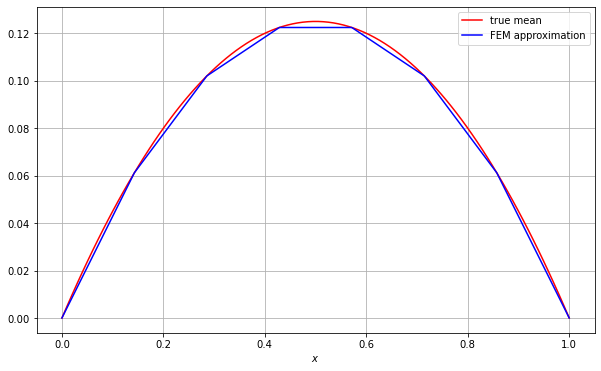

In [ ]:
#hide_input
# use FEniCS to plot μ
x = np.linspace(0,1,100)
μ_true = 0.5*x*(1-x)
plt.plot(x,μ_true,label='true mean',color='red')
plot(μ,label='FEM approximation',color='blue')
plt.legend()
plt.xlabel(r'$x$')
plt.grid()
plt.show()

We can see that the FEM approximation does indeed resemble the true mean!

## Difference between true prior covariance and statFEM prior covariance

The solution $u$ has covariance function $c_u(x,y)$ given by the following expression:

$$c_u(x,y)=\int_{0}^{1}\int_{0}^{1}G(x,w)c_f(w,t)G(t,y)dtdw$$

Where $G(x,y)$ is the Green's function for our problem:

$$G(x,y) = x(1-y)\Theta(y-x) + (1-x)y\Theta(x-y) \text{      for } x,y\in[0,1]$$

(note: $\Theta(x)$ is the Heaviside Step function)

The FEM covariance can be approximated as follows:

$$c_u^{\text{FEM}}(x,y)\approx\sum_{i,j=1}^{J}\varphi_{i}(x)Q_{ij}\varphi_{j}(y)$$

where $Q=A^{-1}MC_{f}M^{T}A^{-T}$ and where the $\{\varphi_{i}\}_{i=1}^{J}$ are the FE basis functions corresponding to the interior nodes of our domain.

with $C_f$ being the kernel matrix of $f$ (evaluated on the FEM grid).

The difference between the covariance operators we are interested in computing is the following contribution to the 2-Wasserstein distance between the true solution GP and the approximate FEM GP:

$$d_W(C_1,C_2) = \operatorname{tr} C_1 +\operatorname{tr} C_2-2\operatorname{tr}\sqrt{C_{1}^{1/2}C_{2}C_{1}^{1/2}}$$

where $C_1, C_2$ are the covariance operators corresponding to $c_u$ and $c_u^{\text{FEM}}$ respectively.

The above quantity will be approximated by fixing a fine grid and computing the cov matrices $\Sigma_1, \Sigma_2$ for the cov operators $C_1, C_2$, respectively, on this grid. We will then utilise the approximation:

$d_W(C_1,C_2)\approx \operatorname{tr} \Sigma_1 +\operatorname{tr} \Sigma_2-2\operatorname{tr}\sqrt{\Sigma_{1}^{1/2}\Sigma_{2}\Sigma_{1}^{1/2}}$

Thus, it will be necessary to write code to form the matrices $\Sigma_1,\Sigma_2$ above. The structure of the approximate $c_u^{\text{FEM}}$ will allow us to compute $\Sigma_2$ in a very efficient manner using FEniCS. This is achieved by noting that we can write:

$$c_u^{\text{FEM}}(x,y)\approx\boldsymbol{\phi}(x)^{T}Q\boldsymbol{\phi}(y)$$

where $\boldsymbol{\phi}(x):=\left(\varphi_1(x),\cdots,\varphi_J(x)\right)^{T}$

Written in this form, it is now easy to see that $\Sigma_2$, whose $ij$-th entry is given by $(\Sigma_2)_{ij}=\boldsymbol{\phi}(x_i)^{T}Q\boldsymbol{\phi}(x_j)$, can be expressed as follows:

$$\Sigma_2=\boldsymbol{\Phi}^{T}Q\boldsymbol{\Phi}$$

where $\boldsymbol{\Phi}$ is a $J\times N$ matrix whose $i$th column is given by $\boldsymbol{\phi}(x_i)$ where $\{x_i\}_{i=1}^{N}$ are the grid points.

Thus, provided we can efficiently compute the matrices $\boldsymbol{\Phi}$ and $Q$ with FEniCS we can efficiently compute the differene between the covariances required.

In order to compute $\Sigma_1$ and the matrix $C_f$ needed for $Q$ we will need to be able to construct a covariance matrix on a grid for a given cov function. We thus will first create a function `kernMat` which assembles the covariance matrix corresponding to the covariance function `k` on a grid `grid`.

In [ ]:
#export
def kernMat(k,grid,parallel=True,translation_inv = False):
    "Function to compute the covariance matrix K corresponding to the covariance kernel k on a grid. This matrix has ijth entry K_ij=k(x_i,x_j) where x_i is the ith point of the grid."
    # get the length of the grid
    n = len(grid)
    # preallocate an n x n array of zeros to hold the cov matrix
    K = np.zeros((n,n))
    
    # check if the cov matrix should be computed in parallel
    if parallel:
        # compute the cov matrix in parallel by computing the upper triangular part column by column
        # set up function to compute the ith column of the upper triangular part:
        def processInput(i):
            return np.array([k(grid[i],grid[j]) for j in range(i,n)])
        
        # get the number of cpu cores present and compute the upper triangular columns in parallel
        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in range(n))

        # store the results in the appropriate positions in K
        #for (i,v) in enumerate(results[0:n-1]):
        for (i,v) in enumerate(results):  # is this correct???
            K[i,i:] = v
        
        # only the upper triangular part has been formed, so use the symmetry of the cov mat to get full K:
        K = K + K.T - np.diag(K.diagonal())
        return K
    elif translation_inv:
        # reshape grid so that it has correct dimensions
        grid = grid.reshape(n,1)
        
        # compute the distance matrix D
        D = cdist(grid,grid)
    
        # evaluate the kernel function using D
        K = k(D)
        return K
    else:
        for i in range(n):
            for j in range(i,n):
                K[i,j] = k(grid[i],grid[j])
        K = K + K.T - np.diag(K.diagonal())
        return K

> Note: This function takes in two optional boolean arguments `parallel` and `translation_inv`. The first of these specifies whether or not the cov matrix should be computed in parallel and the second specifies whether or not the cov kernel is translation invariant. If it is, the covariance matrix is computed more efficiently using the `cdist` function from scipy.

Let's quickly test if this function is working, by computing the cov matrix for white noise, which has kernel function $k(x,y)=\delta(x-y)$. For a grid of length $N$ this should be the $N\times N$ identity matrix.

In [ ]:
# set up the kernel function
# set up tolerance for comparison
tol = 1e-16
def k(x,y):
    if np.abs(x-y) < tol:
        # x == y within the tolerance
        return 1.0
    else:
        # x != y within the tolerance
        return 0.0

# set up grid
N = 21
grid = np.linspace(0,1,N)
K = kernMat(k,grid,True,False) # parallel mode#

# check that this is the N x N identity matrix
assert (K == np.eye(N)).all()

We now create a function `BigPhiMat` to utilise FEniCS to efficiently compute the matrix $\boldsymbol{\Phi}$ defined above.

In [ ]:
#export
def BigPhiMat(J,grid):
    "Function to compute the Phi matrix."
    # create the FEM mesh and function space
    mesh = UnitIntervalMesh(J)
    V = FunctionSpace(mesh,'Lagrange',1)
    # get the tree for the mesh
    tree = mesh.bounding_box_tree()
    # set up a function to compute the ith column of Phi corresponding to the ith grid point
    def Φ(i):
        x = grid[i]
        cell_index = tree.compute_first_entity_collision(Point(x))
        cell = Cell(mesh,cell_index)
        cell_global_dofs = V.dofmap().cell_dofs(cell_index)
        vertex_coordinates = cell.get_vertex_coordinates()
        cell_orientation = cell.orientation()
        data = V.element().evaluate_basis_all(x,vertex_coordinates,cell_orientation)
        return (data,cell_global_dofs,i*np.ones_like(cell_global_dofs))
    # compute all the columns of Phi using the function above
    res = [Φ(i) for i in range(len(grid))]
    # assemble the sparse matrix Phi using the results
    data = np.hstack([res[i][0] for i in range(len(grid))])
    row = np.hstack([res[i][1] for i in range(len(grid))])
    col = np.hstack([res[i][2] for i in range(len(grid))])
    return csr_matrix((data,(row,col)),shape=(V.dim(),len(grid)))

`BigPhiMat` takes in two arguments: `J`, which controls the FE mesh size ($h=1/J$), and `grid` which is the grid in the definition of $\boldsymbol{\Phi}$. `BigPhiMat` returns $\boldsymbol{\Phi}$ as a sparse `csr_matrix` for memory efficiency.

> Note: Note that since FEniCS works with the FE functions corresponding to all the FE dofs and our matrix $\Sigma_2$ only uses the FE functions corresponding to non-boundary dofs we need to account for this in the code. See the source code for `BigPhiMat` to see how this is done.

We now create a function `cov_asssembler` which assembles the approximate FEM covariance matrix on the grid.

In [ ]:
#export
def cov_assembler(J,k_f,grid,parallel,translation_inv):
    "Function to assemble the approximate FEM covariance matrix on the reference grid."
    
    # set up mesh and function space
    mesh = UnitIntervalMesh(J)
    V = FunctionSpace(mesh,'Lagrange',1)
    
    # set up FE grid
    x_grid = V.tabulate_dof_coordinates()
    
    # set up boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    
    bc = DirichletBC(V, 0.0, boundary)
    
    # get the boundary and interior dofs
    bc_dofs = bc.get_boundary_values().keys()
    first, last = V.dofmap().ownership_range()
    all_dofs = range(last - first)
    interior_dofs = list(set(all_dofs) - set(bc_dofs))
    bc_dofs = list(set(bc_dofs))
    
    # set up the function p
    p = Constant(1.0)

    # get the mass and stiffness matrices as sparse csr_matrics
    u = TrialFunction(V)
    v = TestFunction(V)
    
    mass_form = u*v*dx
    a = inner(p*grad(u),grad(v))*dx
    
    M = assemble(mass_form)
    A = assemble(a)
    M = as_backend_type(M).mat()
    A = as_backend_type(A).mat()
    M = csr_matrix(M.getValuesCSR()[::-1],shape=M.size)
    A = csr_matrix(A.getValuesCSR()[::-1],shape=A.size)
    
    # extract the submatrices corresponding to the interior dofs
    M = M[interior_dofs,:][:,interior_dofs]
    A = A[interior_dofs,:][:,interior_dofs]
    
    # get the forcing cov matrix on the interior nodes of the grid
    Σ_int = kernMat(k_f,x_grid[interior_dofs],parallel,translation_inv)
    
    # form the matrix Q in the defintion of the approximate FEM cov mat
    # Note: overwrite Σ_int for memory efficiency.
#     Σ_int = M @ Σ_int @ M.T
    Σ_int = Σ_int @ M.T
    Σ_int = M @ Σ_int
    
    # form B (storing this in Σ_int directly for memory efficiency)
    Σ_int = spsolve(A,Σ_int)
    Σ_int = spsolve(A,Σ_int.T).T
    
    # ensure Σ_int is symmetric
    Σ_int = 0.5*(Σ_int + Σ_int.T)
    
    # get big phi matrix on the grid (extracting only the rows corresponding to the
    # interior dofs)
    Phi = BigPhiMat(J,grid)[interior_dofs,:]
    
    # assemble cov mat on grid using Phi and Σ_int
    Σ = Phi.T @ Σ_int @ Phi
    
    # ensure Σ is symmetric and return
    Σ = 0.5*(Σ + Σ.T)    
    return Σ

`cov_assembler` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J)$
- `k_f`: the covariance function for the forcing $f$
- `grid`: the reference grid where the FEM cov matrix should be computed on
- `parallel`: boolean argument indicating whether the intermediate computation of $C_f$ should be done in parallel 
- `translation_inv`: boolean argument indicating whether the intermediate computation of $C_f$ should be computed assuming `k_f` is translation invariant or not

As a quick demonstration that the code is working, we will compute the true and approximate covariance matrices for a relatively coarse grid. We first set up functions to compute the true covariance matrix $\Sigma_1$:

In [ ]:
# set up kernel functions for f
l_f = 0.4
σ_f = 0.1

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# use quadrature for the true cov function
from scipy import integrate
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function η and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

With these functions we can now compute $\Sigma_1$ as follows:

In [ ]:
# set up a reference grid
N = 21
grid = np.linspace(0,1,N)

# compute Σ_1 using c_u
Σ_1 = kernMat(c_u,grid,True,False)

We now use our function `cov_assembler` to compute $\Sigma_2$:

In [ ]:
J = 20 # choose a FE mesh size
Σ_2 = cov_assembler(J,k_f,grid,False,True)

Let's plot heatmaps of both $\Sigma_1, \Sigma_2$ to compare:

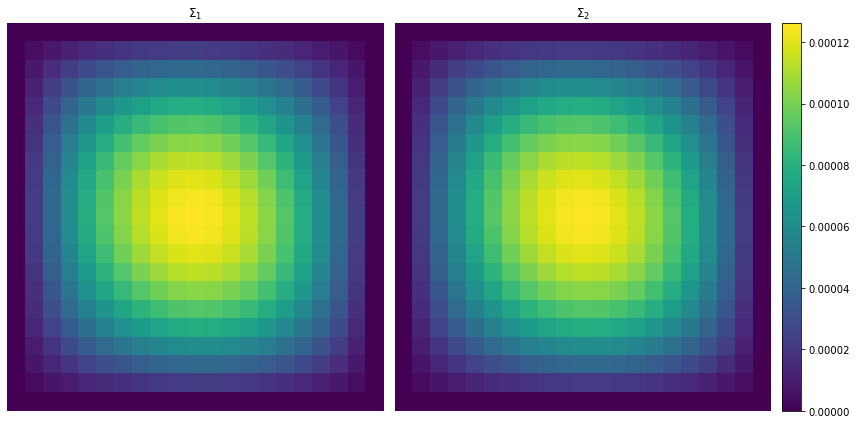

In [ ]:
#hide_input
vmin = min(Σ_1.min(), Σ_2.min())
vmax = max(Σ_1.max(), Σ_2.max())
plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]))
sns.heatmap(Σ_1,cbar=False,
                annot=False,
                xticklabels=False,
                yticklabels=False,
                cmap=cm.viridis,
                ax=axs[0])
axs[0].title.set_text(r'$\Sigma_1$')
sns.heatmap(Σ_2,cbar=False,
                annot=False,
                xticklabels=False,
                yticklabels=False,
                cmap=cm.viridis,
                ax=axs[1])
axs[1].title.set_text(r'$\Sigma_2$')
fig.colorbar(axs[np.argmax([Σ_1.max(), Σ_2.max()])].collections[0], cax=axs[2])
plt.tight_layout()
plt.show()

Even with a relatively coarse reference grid and a relatively coarse FE space it looks as if the approximate FEM covariance is quite similar to the true covariance matrix as can be seen from the heatmaps above. Let's also check how similar they are by utilising `np.linalg.norm` to compute the relative percentage difference:

In [ ]:
#hide_input
print("Relative percentage difference is: %.2f" %(100*np.linalg.norm(Σ_1-Σ_2)/np.linalg.norm(Σ_1)) + "%")

Relative percentage difference is: 0.68%


## Posterior from incorporating sensor readings

Denote by $\nu_{i}=\mathcal{N}(m_{i},\Sigma_{i})$, where $i$ is either the symbol $\star$ or $h$, the true and statFEM prior respectively. When we take $u\sim\nu_{i}$ as our prior, the resulting posterior after incorporating the noisy sensor readings $\mathbf{v}$ at the locations $\{y_{j}\}_{j=1}^{s}$ is given by:

$$u|\mathbf{v}\sim\mathcal{N}\left(m_{u|\mathbf{v}}^{(i)},\Sigma_{u|\mathbf{v}}^{(i)}\right)$$

where we have:

$$m_{u|\mathbf{v}}^{(i)}=m_{i} + \Sigma_{i}S^{\dagger}(\epsilon^{2}I+S\Sigma_{i}S^{\dagger})^{-1}(\mathbf{v}-Sm_{i})$$

$$\Sigma_{u|\mathbf{v}}^{(i)}=\Sigma_{i} - \Sigma_{i}S^{\dagger}(\epsilon^{2}I+S\Sigma_{i}S^{\dagger})^{-1}S\Sigma_{i}$$

where $S$ is the operator which maps a function $g$ to the vector $\left(g(y_1),\cdots,g(y_s)\right)^{T}$.

For brevity we will denote the $s\times s$ matrix which appears above as $B_{\epsilon,i}:=\epsilon^{2}I+S\Sigma_{i}S^{\dagger}=\epsilon^{2}I+C_{Y,i}$ where we have also defined $C_{Y,i}:=S\Sigma_{i}S^{\dagger}$. This matrix has $pq$*-th* entry $c^{(i)}(y_{p},y_{q})$ where $c^{(i)}$ is the covariance function associated with the covariance operator $\Sigma_{i}$.

### Posterior mean

Thus, our posterior mean in both cases has the form:

$$m^{(i)}_{u|\mathbf{v}}(x)=m_{i}(x)+\sum_{p,q=1}^{s}c^{(i)}(x,y_{p})\left(B_{\epsilon,i}^{-1}\right)_{pq}(v_{q}-m_{i}(y_{q}))$$

Note that this can be expressed as:

$$m^{(i)}_{u|\mathbf{v}}(x)=m_{i}(x) - \mathbf{c}^{(i)}(x)^{T}B_{\epsilon,i}^{-1}(\mathbf{m}^{(i)}-\mathbf{v})$$

where $\mathbf{m}^{(i)}:=Sm_{i}=(m_{i}(y_1),\cdots,m_{i}(y_s))^{T}$ and $\mathbf{c}^{(i)}(x):=(c^{(i)}(x,y_1),\cdots,c^{(i)}(x,y_s))^{T}$.

Thus, we require a function to evaluate the posterior means. We will thus create a function `m_post` which evaluates the posterior means. 

In [ ]:
# export
def m_post(x,m,c,v,Y,B):
    "This function evalutes the posterior mean at the point x."
    m_vect = np.array([m(y_i) for y_i in Y]).flatten()
    c_vect = c(x).flatten()
    
    # compute the update term
    update = c_vect @ np.linalg.solve(B,m_vect-v)
    
    # return m_post
    return (m(x) - update)

`m_post` takes in several arguments which are explained below:

- `x`: point where the posterior mean will be evaluated
- `m`: function which computes the prior mean at a given point y
- `c`: function which returns the vector (c(x,y)) for y in Y (note: c is the prior covariance function)
- `v`: vector of noisy sensor readings
- `Y`: vector of sensor locations
- `B`: the matrix $\epsilon^{2}I+C_Y$ to be inverted in order to obtain the posterior

As a quick test to see if the code is working, note that if we choose $\mathbf{c}$ above to be constant at the $j$*-th* standard basis vector and if we take $B$ to be the identity matrix then we should obtain the function $m(x)-m(y_j)+v_j$. This will give us the $v_j$ when evaluated at $y_j$. We will test that this is indeed what we get:

In [ ]:
# choose several prior mean functions to try
m_list = [lambda x: 1.0, lambda x: 0.5*x*(1.0-x), lambda x: np.sin(2*np.pi*x)]

# set up Y and B and v:
Y = np.linspace(0.01,0.99,11)
s = len(Y)
B = np.eye(s)
np.random.seed(42)
v = np.random.randn(s)

# test that we get v_j when evaluated at y_j (and when c is set to be j-th basis vector)
for j in range(s):
    # define c to be j-th basis vector for all x
    def c(x):
        c_vect = np.zeros(s)
        c_vect[j] = 1.0
        return c_vect
    
    # evaluate the posterior mean at jth sensor location and check that this is v_j
    # (this check is done up to a tolerance tol)
    tol = 1e-15
    for m in m_list:
        assert np.abs(m_post(Y[j],m,c,v,Y,B) - v[j]) < tol

### Difference between posterior means

In order to compute the difference between the posterior means we require some more code.

Firstly, we will need code to generate samples from a GP with mean $m$ and cov function $k$ on a grid. We write the function `sample_gp` for this purpose.

In [ ]:
#export
def sample_gp(n_sim,m,k,grid,par=False,trans=True, tol=1e-9):
    "Function to sample a GP with mean m and cov k on a grid."
    # get length of grid
    d = len(grid)
    
    # construct mean vector
    μ = np.array([m(x) for x in grid]).reshape(d,1)
    
    # construct covariance matrix
    Σ = kernMat(k,grid,parallel = par, translation_inv = trans)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it 
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))
    
    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))
    
    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)
    # return the sampled trajectory
    return Y

`sample_gp` takes in several arguments which are explained below:

- `n_sim`: number of trajectories to be sampled
- `m`: mean function for the GP
- `k`: cov function for the GP
- `grid`: grid of points on which to sample the GP
- `par`: boolean argument indicating whether the computation of the cov matrix should be done in parallel
- `trans`: boolean argument indicating whether the computation of the cov matrix should be computed assuming `k` is translation invariant or not
- `tol`: controls the size of the tiny diagonal perturbation added to cov matrix to ensure it is strictly positive definite (defaults to `1e-9`)

As a quick demonstration that the code is working lets generate 10 trajectories of white noise, using the kernel `k` from one of the previous tests:

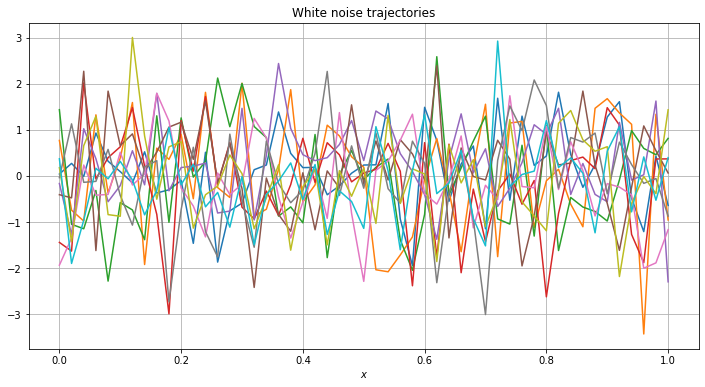

In [ ]:
#hide_input
# set up grid to sample on
N = 51
grid = np.linspace(0,1,N)

# set up mean
def m(x):
    return 0.0

# sample the GP
n_sim = 10
np.random.seed(235)
samples = sample_gp(n_sim,m,k,grid,True,False)
plt.plot(grid,samples)
plt.grid()
plt.xlabel(r'$x$')
plt.title('White noise trajectories')
plt.show()

The next bit of code we require is code to generate noisy sensor reading from our system. We write the function `gen_sensor` for this purpose.

In [ ]:
#export
def gen_sensor(ϵ,m,k,Y,u_quad,grid,par=False,trans=True,tol=1e-9,maxiter=50,require_f=False):
    "Function to generate noisy sensor observations of the solution u on a sensor grid Y."
    
    # get number of sensors from the sensor grid Y
    s = len(Y)
    
    # sample a single f on the grid
    f_sim = sample_gp(1,m,k,grid,par=par,trans=trans,tol=tol)
    
    # create solution function
    # interpolate f to get a function
    f = interp1d(grid,f_sim.flatten(),kind='cubic')
    # use u_quad together with f to compute solution
    def u(x):
        return u_quad(x,f,maxiter=maxiter)
    
    # get solution on grid Y:
    u_Y = np.array([u(y_i) for y_i in Y])
    
    # add N(0,ϵ^2) to each evaluation point
    u_S = u_Y + ϵ*np.random.normal(size=s)
    
    # if require the simulated trajectory of f return this as well, if not just return u_S
    if require_f:
        return u_S, f_sim
    else:
        return u_S

`gen_sensor` takes in several arguments which are explained below:

- `ϵ`: controls the amount of sensor noise
- `m`: mean function for the forcing f
- `k`: cov function for the forcing f
- `Y`: vector of sensor locations
- `u_quad`: function to accurately compute the solution u given a realisation of the forcing f
- `grid`: grid where forcing f is sampled on
- `par`: boolean argument indicating whether the computation of the forcing cov matrix should be done in parallel
- `trans`: boolean argument indicating whether the computation of the forcing cov matrix should be computed assuming `k` is translation invariant or not
- `tol`: controls the size of the tiny diagonal perturbation added to forcing cov matrix to ensure it is strictly positive definite (defaults to `1e-9`)
- `maxiter`: parameter which controls the accuracy of the quadrature used in u_quad (defaults to `50`)
- `require_f` : boolean argument indicating whether or not to also return the realisation of the forcing f (defualts to `False`)

> Important: The function `u_quad` which is passed to `gen_sensor` is assumed to compute the solution using quadrature. This must be done in a particular way and will be demonstrated below. It is also important to choose a fine enough grid for the argument `grid` passed to `gen_sensor` as this affects the solution accuracy.

Let's demonstrate that this code is working. To start we note that due to the form of the Green's function for our problem, we can express the solution $u$ in terms of the forcing $f$ as follows:

$$u(x)=\int_{0}^{1}G(x,y)f(y)\mathrm{d}y=(1-x)\int_{0}^{x}yf(y)\mathrm{d}y+x\int_{x}^{1}(1-y)f(y)\mathrm{d}y$$

We will use this observation when setting up `u_quad` below. We now generate $s=20$ sensor observations with the sensors equally spaced in the interval $(0.01,0.99)$.

In [ ]:
# set up mean and kernel functions for the forcing f
l_f = 0.4
σ_f = 0.1

def m_f(x):
    return 1.0
 
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# set up sensor grid and sensor noise level
s = 20
Y = np.linspace(0.01,0.99,s)
ϵ = 0.1

# set up grid to simulate f on
N = 40
grid = np.linspace(0,1,N+1)

# set up u_quad
def u_quad(x,f,maxiter=50):
    I_1 = integrate.quadrature(lambda w: w*f(w), 0.0, x,maxiter=maxiter)[0]
    I_2 = integrate.quadrature(lambda w: (1-w)*f(w),x, 1.0,maxiter=maxiter)[0]
    return (1-x)*I_1 + x*I_2

# generate the sensor observations
np.random.seed(534)
v_dat,f_sim = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=200,require_f=True)

Plotting these sensor observations with the solution for this particular realisation of the forcing gives:

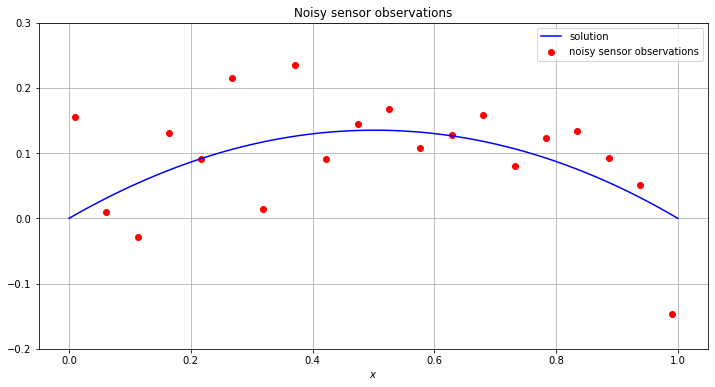

In [ ]:
#hide_input
# plot the sensor readings as well as the true mean
x_range = np.linspace(0,1,100)
f = interp1d(grid,f_sim.flatten(),kind='cubic')
def u(x):
    return u_quad(x,f,maxiter=200)
res = np.array([u(x) for x in x_range])
plt.scatter(Y,v_dat,c='r',label='noisy sensor observations')
plt.plot(x_range,res,c='b',label='solution')
plt.xlabel(r'$x$')
plt.ylim(-0.2,0.3)
plt.title('Noisy sensor observations')
plt.legend()
plt.grid()
plt.show()

The next bit of code needed in order to compute the difference between the posterior means is a way of comparing the two different mean functions. One possible solution is to overload the `UserExpression` class in FEniCS to create custom FEniCS expressions from user defined functions. This will allow us to use our function `m_post` together with `errornorm` from FEniCS to compute the L2 norm of the difference. We thus, create a class called `MyExpression`.

In [ ]:
#export
class MyExpression(UserExpression):
    "Class to allow users to user their own functions to create a FEniCS UserExpression."
    def eval(self, value, x):
        value[0] = self.f(x)
    def value_shape(self):
        return ()

In [ ]:
show_doc(MyExpression,title_level=4)

<h4 id="MyExpression" class="doc_header"><code>class</code> <code>MyExpression</code><a href="" class="source_link" style="float:right">[source]</a></h4>

> <code>MyExpression</code>(**\*`args`**, **\*\*`kwargs`**) :: `UserExpression`

Class to allow users to user their own functions to create a FEniCS UserExpression.

We will now demonstrate how this works, building on the sensor observation example above.

In [ ]:
# set up the true prior mean and the true prior cov needed for the true posterior 
μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)
C_true_s = kernMat(c_u,Y.flatten())
def c_u_vect(x):
    return np.array([c_u(x,y_i) for y_i in Y])
# set up matrix B for posterior
B_true = (ϵ**2)*np.eye(s) + C_true_s

# compute the true posterior mean
def true_post_mean(x):
        return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
    
# set up MyExpression object
μ_true_post = MyExpression()
μ_true_post.f = true_post_mean
μ_true_post

`μ_true_post` now works like a usual FEniCS expression/function. We can evaluate it at a point:

In [ ]:
μ_true_post(0.3)

Or even evaluate it on the nodes of a FEniCS mesh:

In [ ]:
μ_true_post.compute_vertex_values(mesh=UnitIntervalMesh(5))

array([0.        , 0.08179325, 0.12278251, 0.12279555, 0.08181789,
       0.        ])

> Warning: A mesh needs to be passed when using `MyExpression` objects with certain FEniCS methods

We now require code which will create the matrix $C_Y,h$ and the function $\mathbf{c}^{(h)}$ required for the statFEM posterior mean. We will create the function `fem_cov_assembler_post` for this purpose. 

In [ ]:
#export
def fem_cov_assembler_post(J,k_f,Y,parallel,translation_inv):
    "Function to create the matrix C_{Y,h} and the vector function c^{(h)} required for the statFEM posterior mean."
    
    # set up mesh and function space
    mesh = UnitIntervalMesh(J)
    V = FunctionSpace(mesh,'Lagrange',1)
    tree = mesh.bounding_box_tree()
    
    # set up grid
    x_grid = V.tabulate_dof_coordinates()
    
    # set up boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    
    bc = DirichletBC(V, 0.0, boundary)
    
    # get the boundary and interior dofs
    bc_dofs = bc.get_boundary_values().keys()
    first, last = V.dofmap().ownership_range()
    all_dofs = range(last - first)
    interior_dofs = list(set(all_dofs) - set(bc_dofs))
    bc_dofs = list(set(bc_dofs))
    
    # set up the function p
    p = Constant(1.0)

    # get the mass and stiffness matrices
    u = TrialFunction(V)
    v = TestFunction(V)
    
    mass_form = u*v*dx
    a = inner(p*grad(u),grad(v))*dx
    
    M = assemble(mass_form)
    A = assemble(a)
    M = as_backend_type(M).mat()
    A = as_backend_type(A).mat()
    M = csr_matrix(M.getValuesCSR()[::-1],shape=M.size)
    A = csr_matrix(A.getValuesCSR()[::-1],shape=A.size)
    
    # extract the submatrices corresponding to the interior dofs
    M = M[interior_dofs,:][:,interior_dofs]
    A = A[interior_dofs,:][:,interior_dofs]
    
    # get the forcing cov matrix on the interior nodes of the grid
    Σ_int = kernMat(k_f,x_grid[interior_dofs],parallel,translation_inv)

    # form the matrix Q in the defintion of the approximate FEM cov mat
    # Note: overwrite Σ_int for memory efficiency
    Σ_int = M @ Σ_int @ M.T
    
    Σ_int = spsolve(A,Σ_int)
    Σ_int = spsolve(A,Σ_int.T).T
    
    # ensure Σ_int is symmetric
    Σ_int = 0.5*(Σ_int + Σ_int.T)
    
    # get big phi matrix on the sensor grid (only need the interior dofs)
    Phi = BigPhiMat(J,Y)[interior_dofs,:]

    # assemble the FEM cov mat on the sensor grid and ensure it is symmetric
    Σ_s = Phi.T @ Σ_int @ Phi
    Σ_s = 0.5*(Σ_s + Σ_s.T)
    
    # set up function to yield the vector (c(x,y)) for y in Y
    def Φ(x):
        cell_index = tree.compute_first_entity_collision(Point(x))
        cell_global_dofs = V.dofmap().cell_dofs(cell_index)
        cell = Cell(mesh, cell_index)
        vertex_coordinates = cell.get_vertex_coordinates()
        cell_orientation = cell.orientation()
        data = V.element().evaluate_basis_all(x,vertex_coordinates,cell_orientation)
        col = np.zeros_like(cell_global_dofs)
        res = csr_matrix((data,(cell_global_dofs,col)),shape=(V.dim(),1))[interior_dofs,:]
        return res
    
    def c_fem(x):
        return Φ(x).T @ Σ_int @ Phi
    
    #return Σ and c_fem
    return Σ_s, c_fem

`fem_cov_assembler_post` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J$)
- `k_f`: the covariance function for the forcing $f$
- `Y`: vector of sensor locations
- `parallel`: boolean argument indicating whether the computation of the forcing cov mat should be done in parallel
- `translation_inv`: boolean argument indicating whether the computation of the forcing cov mat should be computed assuming `k_f` is translation invariant or not

With all of this code in place we can now finally write the function `m_post_fem_assmebler` which will assemble the statFEM posterior mean function.

In [ ]:
#export
def m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat,par=False,trans=True):
    "Function to assemble the statFEM posterior mean function."
    
    # get number of sensors
    s = len(Y)
    
    # set up mesh and function space
    mesh = UnitIntervalMesh(J)
    V = FunctionSpace(mesh,'Lagrange',1)
    
    # set up boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    
    bc = DirichletBC(V, 0.0, boundary)
    
    # set up the functions p and f
    p = Constant(1.0)
    f = f_bar
    
    # set up the bilinear form for the variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(p*grad(u),grad(v))*dx
    
    # set up linear form
    L = f*v*dx
    
    # solve the variational problem
    μ_fem = Function(V)
    solve(a == L, μ_fem, bc)
    
    # use fem_cov_assembler_post to obtain cov mat on sensor grid and function to compute vector
    # (c(x,y)) for y in Y
    B_fem_s, c_fem = fem_cov_assembler_post(J,k_f,Y.flatten(),parallel=par,translation_inv=trans)
    
    # form B_fem_s by adding noise contribution
    B_fem_s += (ϵ**2)*np.eye(s)
    
    # assemble function to compute posterior mean and return
    def m_post_fem(x):
        return m_post(x,μ_fem,c_fem,v_dat,Y,B_fem_s)
    
    return m_post_fem

`m_post_fem_assembler` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J$)
- `f_bar`: the mean function for the forcing $f$
- `k_f`: the covariance function for the forcing $f$
- `ϵ`: controls the amount of sensor noise
- `Y`: vector of sensor locations
- `v_dat`: vector of noisy sensor observations
- `par`: boolean argument passed to `fem_cov_assembler_post`'s argument `parallel` (defaults to `False`)
- `trans`: boolean argument passed to `fem_cov_assembler_post`'s argument `translation_inv` (defaults to `True`)

> Important: `m_post_fem_assembler` requires `f_bar` to be represented as a FEniCS function/expression/constant.

Let's quickly check that this function is working.

In [ ]:
J = 20
f_bar = Constant(1.0)
m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
# compute posterior mean at a location x in [0,1]
x = 0.3
m_post_fem(x)

Let's also plot the statFEM posterior mean together with the corresponding statFEM prior mean:

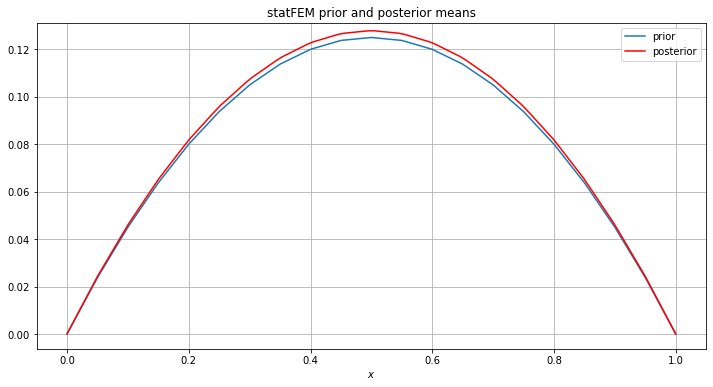

In [ ]:
#hide_input
h = 1/J
m_prior = mean_assembler(h,f_bar)
x_range = np.linspace(0,1,100)
y_range = np.array([m_post_fem(x) for x in x_range])
plot(m_prior,label='prior')
plt.plot(x_range,y_range,label='posterior',c='r')
plt.grid()
plt.xlabel(r'$x$')
plt.title('statFEM prior and posterior means')
plt.legend()
plt.show()

### Posterior covariance

From the form of the posterior covariance operators $\Sigma_{u|\mathbf{v}}^{(i)}$ given in the section **"Posterior from incorporating sensor readings"** we can see that the posterior covariance functions both have the form:

$$c_{u|\mathbf{v}}^{(i)}(x,y) = c^{(i)}(x,y) - \sum_{p,q=1}^{s}c^{(i)}(x,y_p)(B_{\epsilon,i}^{-1})_{pq}c^{(i)}(y_q,y)$$

Note that this can be expressed as:

$$c_{u|\mathbf{v}}^{(i)}(x,y) = c^{(i)}(x,y) - \mathbf{c}^{(i)}(x)^{T}B_{\epsilon,i}^{-1}\mathbf{c}^{(i)}(y)$$

where we have utilised the fact that $c^{(i)}$ are covariance functions and are hence symmetric which allows us to put $\mathbf{c}^{(i)}(y)=(c^{(i)}(y,y_1),\cdots,c^{(i)}(y,y_s))^{T}=(c^{(i)}(y_1,y),\cdots,c^{(i)}(y_s,y))^{T}$.

Thus, we require a function to evalute the posterior covarainces. We will thus create a function `c_post` which evalutes the posterior covariances.

In [ ]:
#export
def c_post(x,y,c,Y,B):
    "This function evaluates the posterior covariance at (x,y)"
    # compute vectors c_x and c_y:
    c_x = np.array([c(x,y_i) for y_i in Y])
    c_y = np.array([c(y_i,y) for y_i in Y])
    
    # compute update term
    update = c_x @ np.linalg.solve(B,c_y)
    
    # return c_post
    return (c(x,y) - update)

`c_post` takes in several arguments which are explained below:

- `x`,`y`: points to evaluate the covariance at
- `c`: function which returns the prior covariance at any given pair $(x,y)$
- `Y`: vector of sensor locations
- `B`: the matrix $\epsilon^{2}I+C_{Y}$ to be inverted in order to obtain the posterior

> Note: The function `c_post` will only be used for the true posterior covariances.

### Difference between posterior covariances

In order to compute the difference between the posterior covariances we require some more code. Since we will be comparing the posterior covariances on a fixed reference grid $\{x_{i}\}_{i=1}^{N}$ we will need to assemble the cov matrices on this grid. I.e. we will require the matrices $\tilde{C}_{X,i}$ with $pq$*-th* entry $c_{u|\mathbf{v}}^{(i)}(x_{p},x_{q})$ for $p,q=1,\cdots N$. For statFEM this matrix can be efficiently assembled by exploiting the form of the statFEM prior and posterior covariance functions, i.e. by noting that we have:

$$\tilde{C}_{X,h} = \Sigma_{X} - \Sigma_{XY}B_{\epsilon,h}^{-1}\Sigma_{XY}^{T}$$

where $\Sigma_{X}:=\Phi_{X}^{T}Q\Phi_{X}$, $\Sigma_{XY}=\Phi_{X}^{T}Q\Phi_{Y}$ and where $\Phi_{X}$ is a $J\times N$ matrix whose $i$*-th* column is given by $\phi(x_{i})$ and similarly $\Phi_{Y}$ is a $J\times s$ matrix whose $i$*-th* column is given by $\phi(y_{i})$ and $Q$ is the matrix defined in the section **"Difference between the true prio covariance and the statFEM prior covariance"**. 

Thus, we can use our function `BigPhiMat` to compute $\tilde{C}_{X,h}$ efficiently. We start by creating the function `post_fem_cov_assembler` which assembles the matrices $\Sigma_{X}, \Sigma_{XY}$, and $\Sigma_{Y}:=\Phi_{Y}^{T}Q\Phi_{Y}$ required for the statFEM posterior covariance.

In [ ]:
#export
def post_fem_cov_assembler(J,k_f,grid,Y,parallel,translation_inv):
    "Function which assembles the matrices Σ_X,Σ_XY, and Σ_Y required for the statFEM posterior covariance."
    
    # set up mesh and function space
    mesh = UnitIntervalMesh(J)
    V = FunctionSpace(mesh,'Lagrange',1)
    
    # set up grid
    x_grid = V.tabulate_dof_coordinates()
    
    # set up boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    
    bc = DirichletBC(V, 0.0, boundary)
    
    # get the boundary and interior dofs
    bc_dofs = bc.get_boundary_values().keys()
    first, last = V.dofmap().ownership_range()
    all_dofs = range(last - first)
    interior_dofs = list(set(all_dofs) - set(bc_dofs))
    bc_dofs = list(set(bc_dofs))
    
    # set up the function p
    p = Constant(1.0)

    # get the mass and stiffness matrices
    u = TrialFunction(V)
    v = TestFunction(V)
    
    mass_form = u*v*dx
    a = inner(p*grad(u),grad(v))*dx
    
    M = assemble(mass_form)
    A = assemble(a)
    M = as_backend_type(M).mat()
    A = as_backend_type(A).mat()
    M = csr_matrix(M.getValuesCSR()[::-1],shape=M.size)
    A = csr_matrix(A.getValuesCSR()[::-1],shape=A.size)
    
    # extract the submatrices corresponding to the interior dofs
    M = M[interior_dofs,:][:,interior_dofs]
    A = A[interior_dofs,:][:,interior_dofs]
    
    # get the forcing cov matrix on the interior nodes of the grid
    Σ_int = kernMat(k_f,x_grid[interior_dofs],parallel,translation_inv)
    
    # form the matrix Q in the defintion of the approximate FEM cov mat
    # Note: overwrite Σ_int for memory efficiency
    Σ_int = M @ Σ_int @ M.T

    Σ_int = spsolve(A,Σ_int)
    Σ_int = spsolve(A,Σ_int.T).T
    
    # ensure Σ_int is symmetric
    Σ_int = 0.5*(Σ_int + Σ_int.T)
    
    # get big phi matrix on the grid
    Phi_grid = BigPhiMat(J,grid)[interior_dofs,:]
    
    # get big phi matrix on the sensor grid
    Phi_Y = BigPhiMat(J,Y)[interior_dofs,:]
    
    # assemble the FEM cov mat on the sensor grid using C_u_full and Phi_Y
    Σ_Y = Phi_Y.T @ Σ_int @ Phi_Y
    
    # assemble the FEM cov mat on the grid using C_u_full and Phi_grid
    Σ_X = Phi_grid.T @ Σ_int @ Phi_grid
    
    # assemble cross term matrix (with ijth entry c(x_i,y_j))
    Σ_XY = Phi_grid.T @ Σ_int @ Phi_Y
    
    # return these sigma matrices
    return Σ_Y, Σ_X, Σ_XY

`post_fem_cov_assembler` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J$)
- `k_f`: the covariance function for the forcing $f$
- `grid`: the fixed reference grid $\{x_{i}\}_{i=1}^{N}$ on which to assemble the posterior cov mat
- `Y`: vector of sensor locations.
- `parallel`: boolean argument indicating whether the computation of the forcing cov mat should be done in parallel
- `translation_inv`: boolean argument indicating whether the computation of the forcing cov mat should be computed assuming `k_f` is translation invariant or not

Finally, we create the function `c_post_fem_assembler` which assembles the statFEM posterior cov mat on the reference grid using the matrices `post_fem_cov_assembler` returns.

In [ ]:
#export
def c_post_fem_assembler(J,k_f,grid,Y,ϵ,par,trans):
    "Function to assemble the statFEM posterior cov mat on a reference grid specified by grid."
    # use post_fem_cov_assembler to get the sigma matrices needed for posterior cov mat
    Σ_Y, Σ_X, Σ_XY = post_fem_cov_assembler(J,k_f,grid,Y,parallel=par,translation_inv=trans)
    
    # create the matrix B
    s = len(Y) # number of sensor points
    B = (ϵ**2)*np.eye(s) + Σ_Y
    
    #form the posterior cov matrix
    update = Σ_XY @ np.linalg.solve(B,Σ_XY.T)
    
    return Σ_X - update

Let's quickly demonstrate that this code is working by computing the statFEM posterior covariance matrix on a reference grid and comparing this to the corresponding statFEM prior.

In [ ]:
# set up reference grid and J
N = 21
grid = np.linspace(0,1,N)
J = 20

# get statFEM prior cov mat on this grid
Σ_prior = cov_assembler(J,k_f,grid,False,True)

# get statFEM posterio cov mat on this grid
Σ_posterior = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)

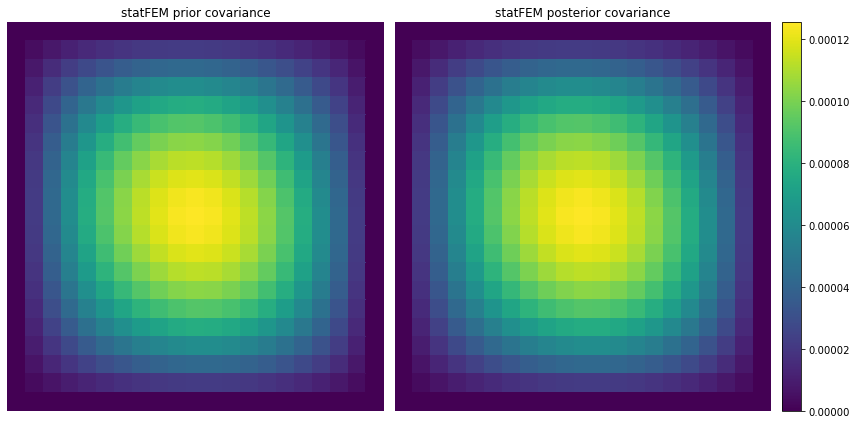

In [ ]:
#hide_input
vmin = min(Σ_prior.min(), Σ_posterior.min())
vmax = max(Σ_prior.max(), Σ_posterior.max())
plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]))
sns.heatmap(Σ_prior,cbar=False,
                annot=False,
                xticklabels=False,
                yticklabels=False,
                cmap=cm.viridis,
                ax=axs[0])
axs[0].title.set_text('statFEM prior covariance')
sns.heatmap(Σ_posterior,cbar=False,
                annot=False,
                xticklabels=False,
                yticklabels=False,
                cmap=cm.viridis,
                ax=axs[1])
axs[1].title.set_text('statFEM posterior covariance')
fig.colorbar(axs[np.argmax([Σ_prior.max(), Σ_posterior.max()])].collections[0], cax=axs[2])
plt.tight_layout()
plt.show()

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_oneDim.ipynb.
Converted index.ipynb.
